**Прогноз оттока клиентов для оператора связи
На основе информации о клиентах оператора связи, построить модель способную прогнозировать отток.**

**Описание услуг**

**Оператор предоставляет два основных типа услуг:**

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**

1. Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
2. Выделенная линия технической поддержки (TechSupport);
3. Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
4. Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

**Данные состоят из файлов, полученных из разных источников:**

**contract.csv** — информация о договоре;

**personal.csv** — персональные данные клиента;

**internet.csv** — информация об интернет-услугах;

**phone.csv** — информация об услугах телефонии.

Во всех файлах столбец **customerID** содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Расшифровка колонок**

**customerID** - идентификационный номер клиента

**BeginDate** - дата начала пользования услугами

**EndDate** - дата окончания пользования услугами

**Type** - тип оплаты: ежемесячный, годовой и тд

**PaperlessBilling** – безналичный расчет

**PaymentMethod** – способ оплаты

**MonthlyCharges** – ежемесячные траты на услуги

**TotalCharges** – всего потрачено денег на услуги

**Dependents** – наличие иждивенцев

**Senior Citizen** – наличие пенсионного статуса по возрасту

**Partner*** – наличие супруга(и)

**MultipleLines** – наличие возможности ведения параллельных линий во время звонка

**План выполнения проекта:**
1. Исследование данных
2. Подготовка данных
3. Подбор моделей
4. Подбор гиперпараметров и признакового пространства на кросс валидации
5. Тестирование
6. Вывод

## Импорт библиотек 

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

random_state = 120922

warnings.filterwarnings("ignore")

In [21]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

datasets = [contract, personal, internet, phone]

## Анализ данных

In [22]:
def view(data):
    print('Обзор', '\n')
    print(data.sample(10))
    print('\n')
    print('Развернутая информация', '\n')
    print(data.info())
    print('\n')
    print('Статистическая составляющая', '\n')
    print(data.describe())

In [23]:
for data in datasets:
    view(data)

Обзор 

             BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
7361-YPXFS  2017-10-01                   No  Month-to-month               No   
7136-RVDTZ  2014-03-01  2020-01-01 00:00:00        One year              Yes   
7176-WRTNX  2014-04-01                   No        Two year              Yes   
7054-LGEQW  2019-09-01  2019-10-01 00:00:00  Month-to-month               No   
6686-YPGHK  2016-01-01  2019-12-01 00:00:00  Month-to-month               No   
0733-VUNUW  2017-10-01  2019-10-01 00:00:00  Month-to-month              Yes   
2777-PHDEI  2019-12-01  2020-01-01 00:00:00  Month-to-month               No   
0617-AQNWT  2014-07-01  2019-11-01 00:00:00        Two year               No   
6500-JVEGC  2014-06-01                   No        One year               No   
4636-JGAAI  2017-04-01                   No  Month-to-month               No   

                        Payment

### Выводы

Пропусков в данных нет, total charges следует приведём к формату числовому. Значения yes/no предлааю заменить чиловыми значениям 1/0. Колонку с номером клиента предлагаю удалить.

## Подготовка данных

Добавим признак на условие пользования да/нет

In [24]:
datasets[2]['internet'] = 'Yes'
datasets[3]['phone'] = 'Yes'

Совместим таблицы

In [25]:
df = contract.join(datasets[1:]).reset_index()

Проверим на дубликаты

In [26]:
df.duplicated().sum()

0

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Видим, что пропуски связаны с тем, что люди не пользовались какими-либо услугами, заменю на 'No'

In [28]:
df = df.fillna('No')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [30]:
df['TotalCharges'].value_counts().sort_index()

          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: TotalCharges, Length: 6531, dtype: int64

In [31]:
df.loc[df['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,...,No,No,No,No,No,No,No,No,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,...,No,No,No,No,No,No,No,No,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,...,No,No,No,No,No,No,No,No,No,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


В данной таблице мы видим клиентов, которые подключились в день, когда начали собирать информацию, особо полезной информации по этим данным не получишь, лучше их удалить, чтобы не вносили шум. 

In [32]:
df = df.loc[df['TotalCharges']!=' ']

In [33]:
df.loc[df['BeginDate'] >= '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone


In [34]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [35]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

In [37]:
gone = df.loc[df['EndDate'] != 'No']
stayed = df.loc[df['EndDate'] == 'No']

In [38]:
gone['EndDate'] = pd.to_datetime(gone['EndDate'])
gone['together'] = round((gone['EndDate'] - gone['BeginDate'])/np.timedelta64(1, 'D'))

In [39]:
gone['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [40]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

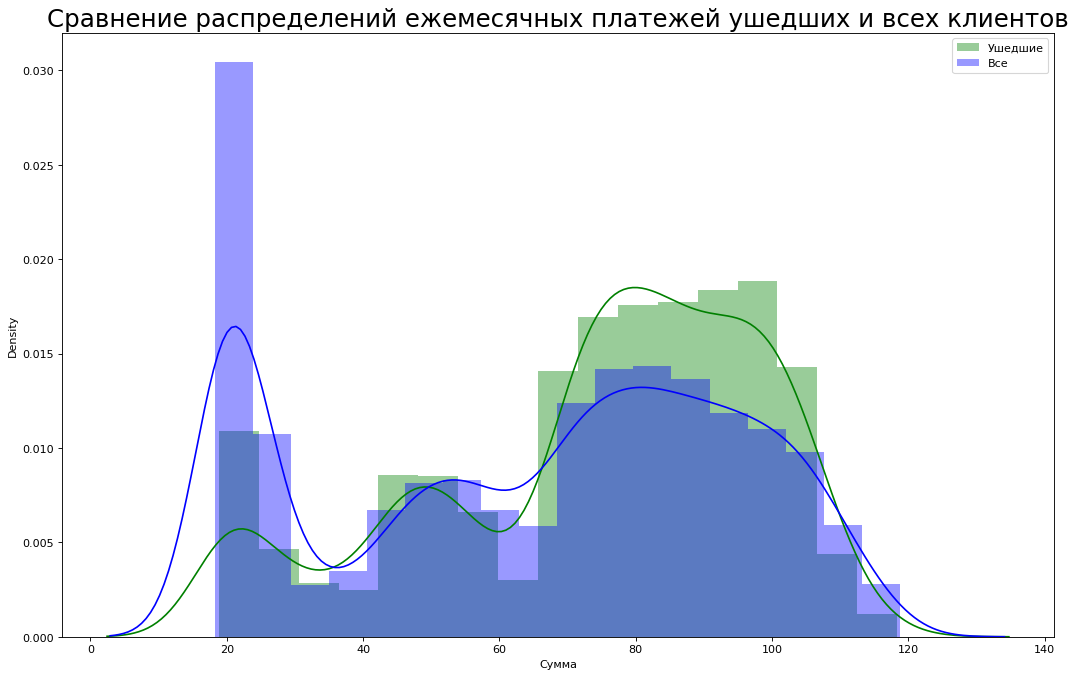

In [41]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(gone['MonthlyCharges'], color="g", label="Ушедшие")
sns.distplot(df['MonthlyCharges'], color="b", label="Все")

plt.title('Сравнение распределений ежемесячных платежей ушедших и всех клиентов', fontsize=22)
plt.legend()
plt.xlabel('Сумма')
plt.show()

У кого ежемесячные траты выше - те чаще уходят

In [42]:
gone['together'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: together, dtype: float64

Четверть уходящих клиентов, уходят в первый месяц

In [43]:
df = df.drop(columns='customerID')

информации мало - удаляем

In [44]:
df.loc[df['EndDate'] != 'No', 'left'] = 1
df.loc[df['EndDate'] == 'No', 'left'] = 0  
df['left'] = df['left'].astype(int)

Вводим бинарный целевой признак 

In [45]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['together'] = round((df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'D')).astype(int)
df = df.drop(columns=['EndDate', 'BeginDate'])

In [46]:
df.together.sort_values()

2133      30
6623      30
3310      30
6633      30
248       30
        ... 
850     2191
6778    2191
2941    2191
4513    2191
932     2191
Name: together, Length: 7032, dtype: int64

In [47]:
df[df.together < 50]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,...,Yes,No,No,No,No,Yes,No,No,0,31
20,Month-to-month,Yes,Electronic check,39.65,39.65,Male,1,No,No,DSL,...,No,Yes,No,No,Yes,Yes,No,No,1,30
22,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,No,...,No,No,No,No,No,No,No,Yes,1,30
27,Month-to-month,No,Electronic check,30.20,30.20,Male,0,Yes,Yes,DSL,...,Yes,No,No,No,No,Yes,No,No,1,30
33,Month-to-month,No,Bank transfer (automatic),20.20,20.20,Male,0,No,No,No,...,No,No,No,No,No,No,No,Yes,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,Month-to-month,No,Mailed check,24.20,24.20,Male,0,No,Yes,DSL,...,No,No,No,No,No,Yes,No,No,0,31
7010,Month-to-month,Yes,Electronic check,74.45,74.45,Female,1,Yes,No,Fiber optic,...,No,No,No,No,No,Yes,Yes,Yes,1,30
7016,Month-to-month,No,Electronic check,49.95,49.95,Female,0,No,No,DSL,...,Yes,No,No,No,No,Yes,No,Yes,0,31
7018,Month-to-month,Yes,Mailed check,70.65,70.65,Male,0,Yes,Yes,Fiber optic,...,No,No,No,No,No,Yes,No,Yes,1,31


Тут можем увидеть, сколько клиент в компании 

In [48]:
df.describe(include='all')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
count,7032,7032,7032,7032.000000,7032.000000,7032,7032.000000,7032,7032,7032,...,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,...,2,2,2,2,2,2,2,2,NaN,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,...,No,No,No,No,No,Yes,No,Yes,NaN,NaN
freq,3875,4168,2365,NaN,NaN,3549,NaN,3639,4933,3096,...,4607,4614,4992,4329,4301,5512,4065,6352,NaN,NaN
mean,NaN,NaN,NaN,64.798208,2283.300441,NaN,0.162400,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265785,987.538538
std,NaN,NaN,NaN,30.085974,2266.771362,NaN,0.368844,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441782,747.153663
min,NaN,NaN,NaN,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,30.000000
25%,NaN,NaN,NaN,35.587500,401.450000,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,275.000000
50%,NaN,NaN,NaN,70.350000,1397.475000,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,883.000000
75%,NaN,NaN,NaN,89.862500,3794.737500,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1676.000000


In [49]:
def cat_type(df, col):
    print(col)
    print(df[col].unique())
    print()
    return df

In [50]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 'gender', 'OnlineBackup', 'Dependents',
              'PaperlessBilling', 'StreamingTV','MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod','phone', 'internet']

In [51]:
for i in categorial:
    cat_type(df, i)

Type
['Month-to-month' 'One year' 'Two year']

InternetService
['DSL' 'Fiber optic' 'No']

Partner
['Yes' 'No']

DeviceProtection
['No' 'Yes']

gender
['Female' 'Male']

OnlineBackup
['Yes' 'No']

Dependents
['No' 'Yes']

PaperlessBilling
['Yes' 'No']

StreamingTV
['No' 'Yes']

MultipleLines
['No' 'Yes']

SeniorCitizen
[0 1]

TechSupport
['No' 'Yes']

OnlineSecurity
['No' 'Yes']

StreamingMovies
['No' 'Yes']

PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

phone
['No' 'Yes']

internet
['Yes' 'No']



In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7032 non-null   object 
 6   SeniorCitizen     7032 non-null   int64  
 7   Partner           7032 non-null   object 
 8   Dependents        7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  internet          7032 non-null   object 


In [53]:
df = pd.get_dummies(df, drop_first=True).astype(int)

In [54]:
## df = df.drop(columns=['Partner_Yes', 'DeviceProtection_Yes','PaymentMethod_Credit card (automatic)','internet_Yes', 'OnlineBackup_Yes','Dependents_Yes'])

Убрал признаки, которые особо не понадобятся в дальнейшей работе

In [55]:
df['MonthlyCharges'].corr(df['TotalCharges'])

0.6511252380434779

Наблюдаем небольшую корреляцию, методом проб и ошибок будем перебором выбирать, как лучше

In [56]:
df = df.drop(columns=['MonthlyCharges'])

In [57]:
df

,TotalCharges,SeniorCitizen,left,together,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,internet_Yes,MultipleLines_Yes,phone_Yes
0,29,0,0,31,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,1889,0,0,1036,1,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
2,108,0,1,61,0,0,1,0,0,1,...,0,1,1,0,0,0,0,1,0,1
3,1840,0,0,1371,1,0,0,0,0,0,...,0,1,0,1,1,0,0,1,0,0
4,151,0,1,61,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1990,0,0,730,1,0,1,0,0,1,...,0,1,0,1,1,1,1,1,1,1
7039,7362,0,0,2191,1,0,1,1,0,0,...,0,0,1,1,0,1,1,1,1,1
7040,346,0,0,337,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
7041,306,1,1,123,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,1,1


In [58]:
one_class_waight = df.loc[df['left'] == 1].shape[0] / df['left'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = [ one_class_waight, zero_class_waight]
class_waights

[0.26578498293515357, 0.7342150170648465]

Существует дисбаланс классов целевого признака

In [59]:
train,test = train_test_split(df, test_size=0.25, random_state = 120922, stratify= df['left'])

In [60]:
def features_target_split(df,target):
    features = df.drop(target, axis=1)
    target = df[target]
    return features, target

In [61]:
features_test, target_test = features_target_split(test,'left')
features_train, target_train = features_target_split(train,'left')

## Подбор моделей 

In [62]:
models_scors = pd.DataFrame(columns = ['model', 'roc_auc'])

**RFC**

In [63]:
%%time
RF_model = RandomForestClassifier(random_state=120922, class_weight='balanced')

parameters = [{'max_depth': [7],
               'n_estimators': [270]}]

RF_model_gscv = GridSearchCV(RF_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
RF_model_gscv.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'RandomForest',
                     'roc_auc' : RF_model_gscv.best_score_}, ignore_index=True)

RF_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 2.71 s, sys: 16 ms, total: 2.73 s
Wall time: 2.74 s


{'max_depth': 7, 'n_estimators': 270}

**CBC**

In [64]:
%%time
CBC_model = CatBoostClassifier(random_state=120922, silent=True, class_weights=class_waights)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'CatBoostClassifier',
                     'roc_auc' : CBC_model_gscv.best_score_}, ignore_index=True)

CBC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 2.51 s, sys: 200 ms, total: 2.71 s
Wall time: 19.5 s


{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

**LGBM**

In [65]:
%%time
LGBMC_model = LGBMClassifier(random_state=120922, class_weight='balanced')

parameters = [{'max_depth': [2],
               'learning_rate': [0.1],
               'n_estimators': [700]}]

LGBMC_model_gscv = GridSearchCV(LGBMC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
LGBMC_model_gscv.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'LGBMClassifier',
                     'roc_auc' : LGBMC_model_gscv.best_score_ }, ignore_index=True)

LGBMC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 38 s, sys: 367 ms, total: 38.4 s
Wall time: 38.6 s


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 700}

In [66]:
models_scors

,model,roc_auc
0,RandomForest,0.855420
1,CatBoostClassifier,0.920580
2,LGBMClassifier,0.900848


CBC показал лучший результат - подбираем параметры для него

### Подбор гиперпараметров 

In [67]:
%%time
CBC_model = CatBoostClassifier(random_state=120922, silent=True, class_weights=class_waights)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)


CBC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 2.48 s, sys: 200 ms, total: 2.68 s
Wall time: 13.9 s


{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

In [68]:
CBC_model_gscv.best_score_

0.9205795564400958

In [69]:
features_train_importance = pd.DataFrame({'name' : features_train.columns,
                                          'importance' : CBC_model_gscv.best_estimator_.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
features_train_importance

,name,importance
2,together,75.550435
0,TotalCharges,7.512178
4,Type_Two year,5.632345
12,InternetService_Fiber optic,2.691443
3,Type_One year,1.814518
20,internet_Yes,1.221754
7,PaymentMethod_Electronic check,0.860702
18,StreamingTV_Yes,0.548591
22,phone_Yes,0.522024
14,OnlineSecurity_Yes,0.456450


## Тест

In [70]:
print('ROC-AUC : {:.2f}'.format(roc_auc_score(target_test,
                                        CBC_model_gscv.best_estimator_.predict_proba(features_test)[:, 1])))

ROC-AUC : 0.93


In [71]:
print('Accuracy : {:.2%}'.format(accuracy_score(target_test,
                                                CBC_model_gscv.best_estimator_.predict(features_test))))

Accuracy : 86.41%


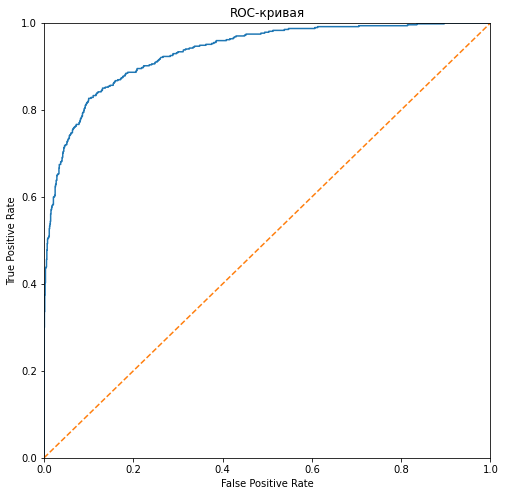

In [72]:
fpr, tpr, thresholds = roc_curve(target_test, CBC_model_gscv.best_estimator_.predict_proba(features_test)[:, 1])

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Площадь составила 0.93, точность 86.41%
Продолжительность пользования - явилась самым важным признаком

## Отчет 

 ### Описание выполненных действий относительно плана 
1. **Исследовательский анализ данных.**

Был произведен визуальный осмотр данных, статистической информации, проверка на пропуски и дубликаты.

2. **Подготовка данных.**

Удалена дата подключения. Проанализирован период через который происходит прекращение пользования услугами.   Произведено объединение таблиц и добавление признаков "пользование интернетом" и "пользование телефонией". Образовавшиеся пропуски были заполнены значением "No", так как явно было указано, что если клиента нет в таблице, значит он не пользуется услугой. Удален признак "ежемесячный платеж" в связи с корреляцией с другим количественным признаком. Построен график распределений всех клиентов, и тех кто ушел.

- Добавили признак на условие пользования услугами да/нет
- Удалили 'customerID'
- Удалили признак 'MonthlyCharges'

3. **Подбор моделей.**

На кросс валидации было произведено сравнение трех моделей.

**CatBoostClassifier** показала лучшие результаты. 

4. **Подбор гиперпараметров.**

Были отобраны мало информативные признаки, после этого ещё раз были подобраны гиперпараметры.

5. **Тестирование.**

Модель была протестирована на тестовой выборке выведены метрики **ROC-AUC : 0.93, Accuracy : 86.41%** и построена ROC-кривая. 

### Возникшие проблемы
1. Проблемы с обработкой данных, в черновой версии долго не мог выйти на пробелы, но потом удалось.
2. Поиск фиктивных признаков - там тоже немного запутался. 

### Ключевые шаги и наиболее важные моменты
В первую очередь хотелось бы отметить, что в любом проекте нужно быть очень внимательным и никуда не спешить. 
Что касается технической части выполнения проекта, могу выделить у себя проблему, минимальных движений в плане раскрутки и осмотра данных/тестирования моделей и тд. 
Поэтому в дальнейшей работе, буду стараться больше и информативнее представлять свои шаги по работе и более развернуто давать обоснования к выполненным действиям. 
А что касается данных то, наиболее важным для меня моментом было введение целевого признака и поиск данных для обучения модели. 
### Описание модели 
На кросс валидации было произведено сравнение трех моделей: RandomForestClassifier, CatBoostClassifier, LGBMClassifier. 

- model_________________roc_auc
- RandomForest__________0.855420
- CatBoostClassifier____0.920580
- LGBMClassifier________0.900848

**CatBoostClassifier {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}** показала лучшие результаты:
**ROC-AUC : 0.93, Accuracy : 86.41%**
